## Analysis of newspaper front page pdfs.

First, locate U.S. newspapers. 

Second, text mining to local headlines. 

Third, text analysis on headlines about government shutdown. 


In [2]:
import os

import time

import pandas as pd #to write/read/work with csv files.
import numpy as np #to do math
import matplotlib.pyplot as plt #To make plots
import seaborn as sns #for additional plot features
%matplotlib inline

from pdfminer.pdfparser import PDFParser
from pdfminer.pdfdocument import PDFDocument
from pdfminer.pdfpage import PDFPage
# From PDFInterpreter import both PDFResourceManager and PDFPageInterpreter
from pdfminer.pdfinterp import PDFResourceManager, PDFPageInterpreter
from pdfminer.pdfdevice import PDFDevice
# Import this to raise exception whenever text extraction from PDF is not allowed
from pdfminer.pdfpage import PDFTextExtractionNotAllowed
from pdfminer.layout import LAParams, LTTextBox, LTTextLine
from pdfminer.converter import PDFPageAggregator


import nltk
from nltk import word_tokenize
from nltk.util import ngrams
from collections import Counter
from nltk.corpus import stopwords

import sklearn.feature_extraction.text as TEXT

# 1. Extracting headline text from pdfs

A previous notebook downloaded the front pages of the collection of papers offered by the Newseum. However, extracting text from pdfs is a painful thing. The code the gives pdfs structure is designed to have the same layout no matter what type of system is opening the file. That means the positions of all the text and pictures are hard coded into the pdf.

I can extract the locations and dimensions of the textlines and textboxes that contain all the text in the pdf, as well as the text itself. From these bits I'll piece together what may be a headline by only taking text will a larger than average font size.

In [1]:
#shamelessly copied from https://gist.github.com/vinovator/c78c2cb63d62fdd9fb67
def headlines(filename):
    try:
        my_file = os.path.join(base_path + "/" + filename)
        password = ""
        extracted_text = ""
        extracted_text_plus=[];
        # Open and read the pdf file in binary mode
        fp = open(my_file, "rb")
        # Create parser object to parse the pdf content
        parser = PDFParser(fp)
        # Store the parsed content in PDFDocument object
        document = PDFDocument(parser, password)
        # Check if document is extractable, if not abort
        #if not document.is_extractable:
        #    raise PDFTextExtractionNotAllowed
        # Create PDFResourceManager object that stores shared resources such as fonts or images
        rsrcmgr = PDFResourceManager()
        # set parameters for analysis
        laparams = LAParams()
        # Create a PDFDevice object which translates interpreted information into desired format
        # Device needs to be connected to resource manager to store shared resources
        # device = PDFDevice(rsrcmgr)
        # Extract the decive to page aggregator to get LT object elements
        device = PDFPageAggregator(rsrcmgr, laparams=laparams)
        # Create interpreter object to process page content from PDFDocument
        # Interpreter needs to be connected to resource manager for shared resources and device 
        interpreter = PDFPageInterpreter(rsrcmgr, device)
        # Ok now that we have everything to process a pdf document, lets process it page by page
        for page in PDFPage.create_pages(document):
            # As the interpreter processes the page stored in PDFDocument object
            interpreter.process_page(page)
            # The device renders the layout from interpreter
            layout = device.get_result()
            # Out of the many LT objects within layout, we are interested in LTTextBox and LTTextLine
            for lt_obj in layout:
                #print(lt_obj)
                #extracted_text_plus.append(lt_obj)
                if isinstance(lt_obj, LTTextBox) or isinstance(lt_obj, LTTextLine):
                    extracted_text_plus.append(lt_obj)
            #print(layout)
        #close the pdf file
        fp.close()
        #save the text
        #with open(log_file, "wb") as my_log:
        #    my_log.write(extracted_text.encode("utf-8"))
       
    
    
    ###Finally getting to my contributions.###
    #Headlines are assumed to be large text. By comparing the number of lines of text in a textbox
    #with the height of the textbox, the average size of the text can be found.
    #Text that's larger than average is kept.
    
        df=pd.DataFrame()
        df['num']=0;
        df['height']=0;
        df['text']=''
        nums=[];
        heights=[];
        for n in range(0,len(extracted_text_plus)):
            cords=str(extracted_text_plus[n]).split(' ')[1].split(',')
            text=' '.join(str(extracted_text_plus[n]).split(' ')[2:])
            h=float(cords[3])-float(cords[1])
            #nums.append(n)
            #heights.append(h)
            df.loc[n,'num']=n
            df.loc[n,'height']=h
            df.loc[n,'text']=text
        df['newlines']=0;
        for x in range(0,len(df)):
            df.loc[x,'newlines']=df.loc[x,'text'].count('\\n')
        df['text height']=df['height']/df['newlines']
        df2=df.loc[df['text height']>df['text height'].mean()+df['text height'].std(),:].copy()
        df2.sort_values(by='text height',ascending=False, inplace=True)
        df2.reset_index(inplace=True)
        del df2['index']
        
        
        return df2
    except:
        return ''

Currently have records for 9 days. 3 about the 2013 shutdown (day 1, day 2, final day), all 4 for Jan. 2018 shutdown, and all 2 for Feb. 2018 shutdown.

In [3]:
path="C:/path/to/pdfs"
folders_pdf=os.listdir(path)
folders_pdf

['20131001',
 '20131002',
 '20131017',
 '20180120',
 '20180121',
 '20180122',
 '20180123',
 '20180208',
 '20180209']

A few of the pdfs in these recordings hang the following script. So, I had to do a bit of manipulation to job offending pdfs from each day's collection. Never more than 2-3 pdfs/day. But it means this isn't entirely automated.

In [6]:
folders_pdf=['20180209']
folders_pdf

['20180209']

In [ ]:
for datestamp in folders_pdf:
#for datestamp in ['20131002']:
    print(datestamp)
    base_path=os.path.join(path+"/"+datestamp);
    files_pdf=os.listdir(base_path);
    files_pdf=[file for file in files_pdf if file[-3:]=='pdf'];
    df_t=pd.DataFrame()
    df_t['files']=files_pdf
    cut1=list(df_t.loc[df_t['files'].str.split("_").apply(lambda x: len(x))==2,:].index.values)
    cut2=list(df_t.loc[df_t['files'].str.split("_").apply(lambda x: x[1]).str.len()==2,:].index.values)
    cut=cut2+cut1
    df_US=df_t.loc[cut,:].copy()
    df_US.reset_index(inplace=True)
    del df_US['index']
    if datestamp=='20180208':
        df_US.drop(df_US.index[357], inplace=True) #for 20131002 only
        df_US.drop(df_US.index[358], inplace=True) #for 20131002 only
        df_US.drop(df_US.index[359], inplace=True) #for 20131002 only
        df_US.reset_index(inplace=True)
        del df_US['index']    
    print(len(df_US))
    df_hl=pd.DataFrame()
    df_hl['filename']=''
    df_hl['headline']=''
    c=0
    for f in range(0,len(df_US)):

        HL=headlines(df_US.loc[f,'files'])
        if f%1==0:
            print(f)

        for l in range(0,len(HL)):
            df_hl.loc[c,'filename']=df_US.loc[f,'files'];
            df_hl.loc[c,'headline']=HL.loc[l,'text'].replace("'","")[:-1].replace("\\n"," ").strip()
            c=c+1
    day=datestamp
    df_hl.to_csv(os.path.join(base_path + "/" + "headlines2%s.csv"%(day)),index=False)

## 2. Studies of the headline text

Once I have finally extracted the potential headlines from the pdfs to a csv file, it's time to take a look at what I've gathered. First I'll combine everything into a single dataframe. Some additional cleaning will have to be done before I can go about doing any type of analysis.

In [3]:
path="C:/Users/Kyle/Documents/Blog Posts/Newseum"
folders_pdf=os.listdir(path)
folders_pdf

['20131001',
 '20131002',
 '20131017',
 '20180120',
 '20180121',
 '20180122',
 '20180123',
 '20180208',
 '20180209']

In [30]:
df_headlines=pd.DataFrame()
len(df_headlines)

0

In [31]:
df_headlines=pd.DataFrame()
for datestamp in folders_pdf:
    base_path=os.path.join(path+"/"+datestamp)
    day=datestamp
    df_hl=pd.read_csv(os.path.join(base_path + "/" + "headlines2%s.csv"%(day)),encoding = "ISO-8859-1",dtype={'filename': str,'headline': str})
    if len(df_headlines)==0:
        df_headlines=df_hl.copy()
    else:
        df_headlines=pd.concat([df_headlines,df_hl])

In [32]:
df_hl=df_headlines.copy()

In [33]:
print('Currently, there are %s potential headlines in this dataframe.' %(len(df_hl)))

Currently, there are 24345 potential headlines in this dataframe.


In [34]:
df_hl.reset_index(inplace=True)
del df_hl['index']

Copying from pdfs was imperfect. Let me get rid of headlines that have "cid:". This can most easily be seen by looking at a potential headline with 'cid:' in it and one that does not:

In [35]:
df_hl.loc[0,'headline']

'(cid:35)(cid:72)(cid:73)(cid:69)(cid:70)(cid:0)(cid:83)(cid:65)(cid:89)(cid:83)(cid:0)(cid:80)(cid:79)(cid:76)(cid:73)(cid:67)(cid:69)(cid:0)(cid:70)(cid:65)(cid:67)(cid:69)(cid:0)(cid:83)(cid:84)(cid:65)(cid:70)(cid:70)(cid:73)(cid:78)(cid:71)(cid:0)(cid:83)(cid:72)(cid:79)(cid:82)(cid:84)(cid:65)(cid:71)(cid:69)(cid:0)(cid:78)(cid:69)(cid:88)(cid:84)(cid:0)(cid:89)(cid:69)(cid:65)(cid:82)'

In [36]:
df_hl.loc[10,'headline']

'Congress Squabbles As Shutdown Nears'

In [37]:
df_hl=df_hl.loc[~df_hl['headline'].str.contains('cid:').fillna(False),:].copy()

In [38]:
df_hl.reset_index(inplace=True)
del df_hl['index']

In [39]:
print('Currently, there are %s potential headlines in this dataframe.' %(len(df_hl)))

Currently, there are 23952 potential headlines in this dataframe.


# Text analysis

Some basic questions I can ask include, what sort of words are in the headlines?

We can answer that a few ways. 1 is just by counting all the various words up:

In [40]:
corpora=' '.join(df_hl['headline'].astype(str).str.lower().values)
corpora_VC=pd.Series(corpora.split(' ')).value_counts()

In [41]:
corpora_VC[0:20]

              10717
to             3748
in             2521
for            2141
the            2056
of             1775
a              1605
on             1450
shutdown       1301
at              745
new             641
with            582
and             558
is              508
as              498
deal            476
government      467
state           389
budget          387
senate          362
dtype: int64

Sure enough, the word "shutdown" is a common theme. That's a good thing to see! But there's a bunch of chaff as well. Words that are so common in the English language that they don't carry much information (e.g. "to" or "in"). I can remove those 'stopwords' and also make this more visually appealing by creating word clouds of the headlines for each day:

In [43]:
df_hl['date']=df_hl.loc[:,'filename'].str[0:8]

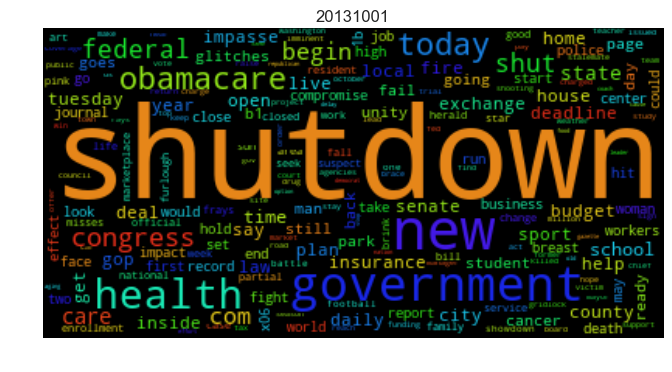

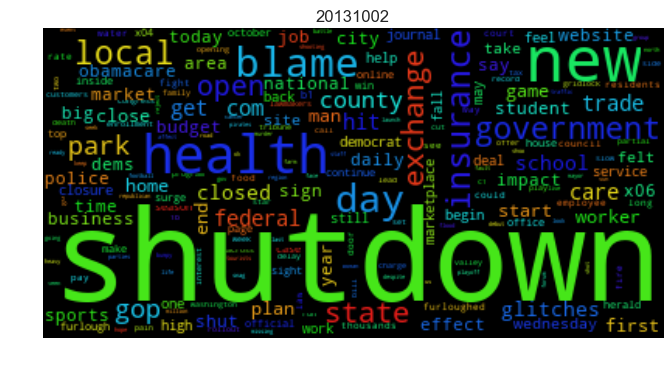

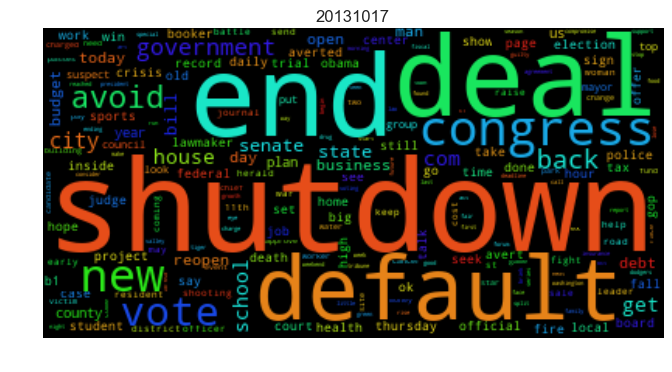

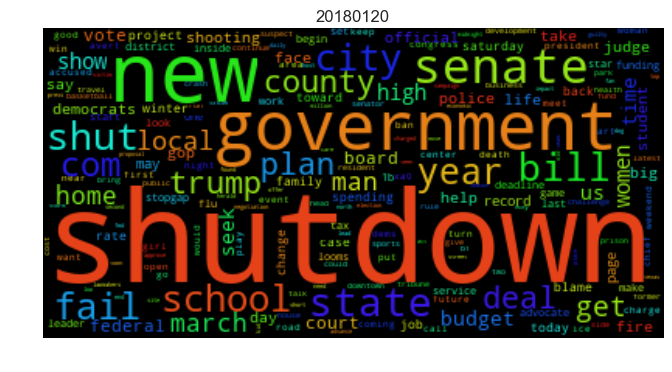

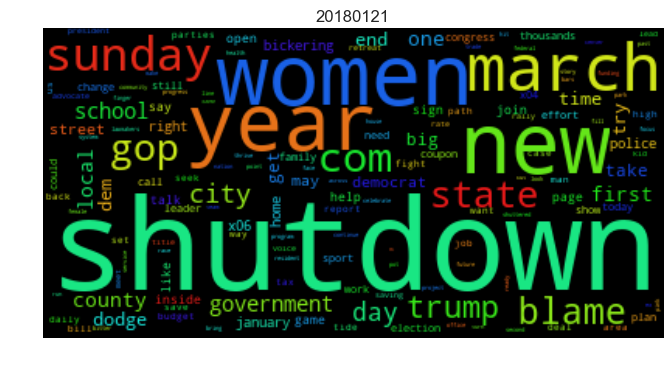

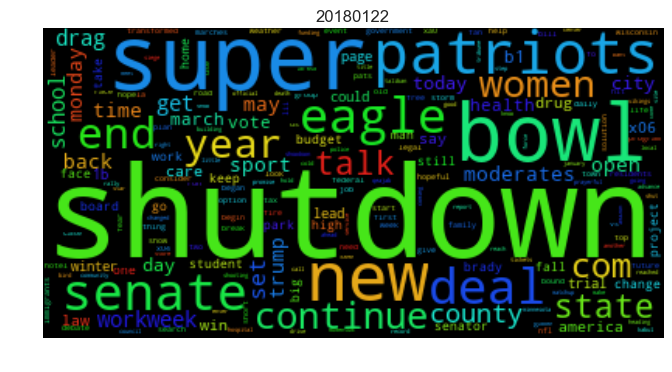

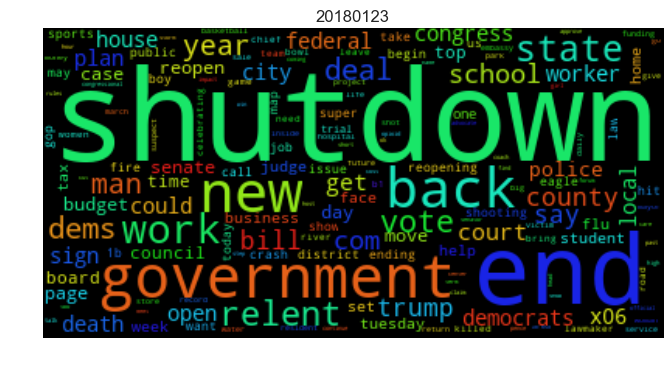

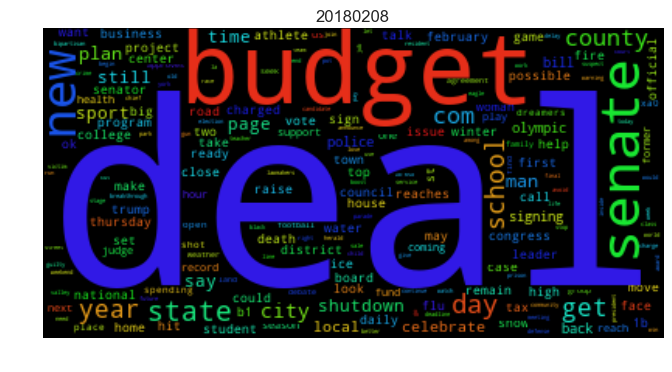

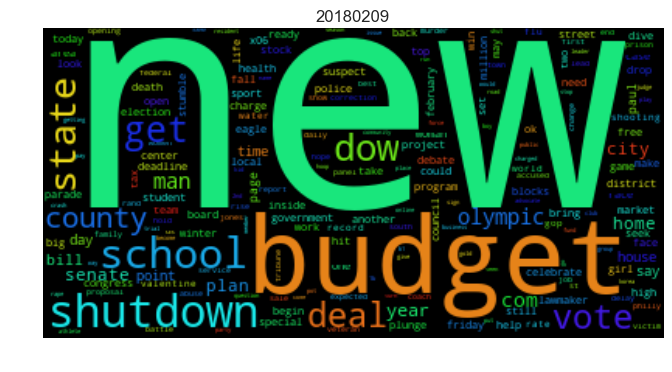

In [44]:
#full headlines
for date in df_hl.date.unique():
    corpora=' '.join(df_hl.dropna().loc[(df_hl.loc[:,'date']==date),'headline'].str.lower().str.replace('uf0ea',''))
    from wordcloud import WordCloud
    wordcloud=WordCloud(relative_scaling=1.0,stopwords=stopwords.words('english')).generate(corpora)
    fig=plt.figure(figsize=(8,12))
    plt.imshow(wordcloud, interpolation='bilinear');
    plt.title(date)
    plt.axis('off');
    plt.show()

So, something that jumps out is that many headlines have to do with the shutdown. Many others have to do with sports, other bits of politics, or local news. It might be nice to distinguish between those 2 groups.

A nice way of doing that would be with n-grams and a count matrix. (Still to come)